# Multiclass Logistic Regression From Scratch

给定输入向量$z$，softmax做两件事情：
* 按元素级别(element-wise)将向量$z$指数化为$e^z$，强制性地让所有的值变为严格正数。
* 正则化其和为1，公式为：
$$softmax(z) = \frac{e^z}{\sum^k_{i=1}e^{z_i}}$$

对于$k$个输出，我们的神经网络变化如下：

![](https://github.com/zackchase/mxnet-the-straight-dope/blob/master/img/simple-softmax-net.png?raw=true)

我们最终的输出结果变化如下，其中$W$为参数矩阵：

$$\hat{y} = \text{softmax}(\boldsymbol{x} W + \boldsymbol{b})$$

## batch training

假设我们有d个输入和k个输出，我们写出上面表达式的维度信息：

$$\underset{1 \times k}{\boldsymbol z} = \underset{1 \times d}{\boldsymbol{x}} \underset{d \times k}{W} + \underset{1 \times k}{\boldsymbol{b}}$$

通常我们使用one-hot编码来对输出结果进行编码，例如$\hat y = 5$的one-hot编码为$\boldsymbol {\hat y}_{one-hot} = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]$(当我们的问题时10分类问题的时候)，所以$\hat{y} = \text{softmax}(\boldsymbol z)$变成
$$\underset{1 \times k}{\boldsymbol{\hat{y}}_{one-hot}} = \text{softmax}_{one-hot}(\underset{1 \times k}{\boldsymbol z})$$

假若我们有m个batch的训练样本，由于选择使用了行向量，我们可以得到矩阵 $\underset{m \times d}{\boldsymbol X}$，这是每个训练样本$x_i$的垂直叠加，

$$
X=
\begin{bmatrix}
    \boldsymbol x_1 \\
    \boldsymbol x_2 \\
    \vdots \\
    \boldsymbol x_m
\end{bmatrix}
=
\begin{bmatrix}
    x_{11} & x_{12} & x_{13} & \dots  & x_{1d} \\
    x_{21} & x_{22} & x_{23} & \dots  & x_{2d} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    x_{m1} & x_{m2} & x_{m3} & \dots  & x_{md}
\end{bmatrix}
$$

在批训练的情形下，${\boldsymbol{\hat{y}}_{one-hot}} = \text{softmax}({\boldsymbol z})$变成
$$Y = \text{softmax}(Z) = \text{softmax}(XW + B)$$

偏置此时产生了变化，因为有$m$的训练样本，每个训练样本为$k$维，则每个训练样本的偏置为$k$维，那么$m$个训练样本的偏置为$\underset{m \times k}{B}$，其中

$$ B = 
\begin{bmatrix}
    \boldsymbol b \\
    \boldsymbol b \\
    \vdots \\
    \boldsymbol b
\end{bmatrix}
=
\begin{bmatrix}
    b_{1} & b_{2} & b_{3} & \dots  & b_{k} \\
    b_{1} & b_{2} & b_{3} & \dots  & b_{k} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    b_{1} & b_{2} & b_{3} & \dots  & b_{k}
\end{bmatrix}$$

行矩阵$\underset{m \times k}{\boldsymbol{Z}}$的每一行代表一个$k$维的训练样本，softmax函数作用于矩阵$Z$的每一行然后返回一个$\underset{m \times k}{\boldsymbol{Y}}$的矩阵，每一行代表一个训练样本的$one-hot$编码预测值。

## 导入库函数

In [1]:
import numpy as np
import mxnet as mx
from mxnet import nd
from mxnet import autograd
from mxnet import gluon
mx.random.seed(1)

import matplotlib.pyplot as plt

## 设置context

In [2]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()
# model_ctx = mx.gpu()

## 通过``gluon``读取MNIST数据集

In [3]:
# 定义transform函数，将data和label变为浮点数，并且将pixel正则化至[0,1]区间
def transform(data, label):
    return data.astype(np.float32) / 255, label.astype(np.float32)

mnist_train = gluon.data.vision.MNIST(train=True, transform=transform)
mnist_test = gluon.data.vision.MNIST(train=False, transform=transform)

In [4]:
# test
data, label = mnist_train[1]
print(data.shape)
print(label)

(28, 28, 1)
0.0


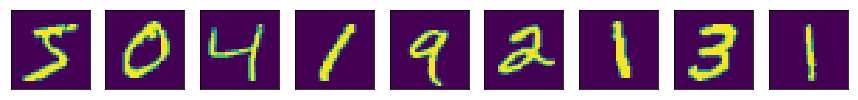

['五', '零', '四', '一', '九', '二', '一', '三', '一']

In [5]:
def show_images(images):
    n = images.shape[0]
    f, figs = plt.subplots(1, n, figsize=(15, 15))
    for i in range(n):
        figs[i].imshow(images[i].reshape((28,28)).asnumpy())
        figs[i].axes.get_xaxis().set_visible(False)
        figs[i].axes.get_yaxis().set_visible(False)
    plt.show()

def get_image_text(img_label):
    n = img_label.shape[0]
    text_labels = ['零','一','二','三','四','五','六','七','八','九']
    return [text_labels[int(img_label[i])] for i in range(n)]
    
data, label = mnist_train[0:9]
show_images(data)
get_image_text(label)

##  记录数据和标签的shape

一般来说，我们不希望我们的模型代码太在意输入数据的确切形状。这样我们就可以在不改变后面的代码的情况下切换不同的数据集。所以我们习惯于定义变量来保存输入和输出的数量。

In [6]:
data_train, label_train = mnist_train[:]
data_test, label_test = mnist_test[:]
print(data_train.shape)
print(label_train.shape)
print(data_test.shape)
print(label_test.shape)

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


In [7]:
num_inputs = 784
num_outputs = 10
num_examples = 60000

机器学习库通常期望以（batch，channel，height，width）格式查找图像。但是，大多数可视化的库以（height，width，channel）格式村存储。所以我们把我们的图像转换成预期的形状。在这种情况下，matplotlib需要使用RGB通道的（height, width）或（height, width, channel），所以让我们把我们的单通道广播到三通道。

In [8]:
image, label = mnist_train[0]
im = nd.tile(image, (1,1,3)) # 可以这样理解 第1 2通道不变，第三通道扩展三倍
im.shape

(28, 28, 3)

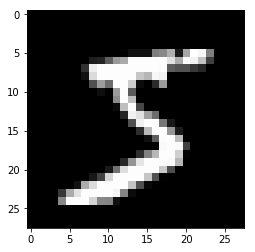

In [9]:
plt.imshow(im.asnumpy())
plt.show()

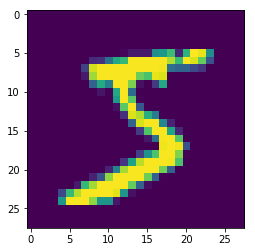

In [10]:
plt.imshow(image.reshape((28,28)).asnumpy())
plt.show()

## 关于``nd.tile``的用法

可以这样理解，如果复试为reps=(2,3)，就是将第一维度乘以2倍，第二维度乘以3倍；

In [11]:
x = nd.array([[1,2],[3,4]])
x


[[ 1.  2.]
 [ 3.  4.]]
<NDArray 2x2 @cpu(0)>

In [12]:
nd.tile(x, reps=(2,3))


[[ 1.  2.  1.  2.  1.  2.]
 [ 3.  4.  3.  4.  3.  4.]
 [ 1.  2.  1.  2.  1.  2.]
 [ 3.  4.  3.  4.  3.  4.]]
<NDArray 4x6 @cpu(0)>

In [13]:
nd.tile(x, reps=(2,))


[[ 1.  2.  1.  2.]
 [ 3.  4.  3.  4.]]
<NDArray 2x4 @cpu(0)>

In [14]:
nd.tile(x, reps=(1,1,3))


[[[ 1.  2.  1.  2.  1.  2.]
  [ 3.  4.  3.  4.  3.  4.]]]
<NDArray 1x2x6 @cpu(0)>

## 使用``gluon``加载数据

In [15]:
batch_size = 64    
train_data = mx.gluon.data.DataLoader(mnist_train, batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(mnist_test, batch_size, shuffle=False) # 测试集一般不需要shuffle

## 定义模型参数

输入784，输出10，共60000个训练样本

In [16]:
W = nd.random.normal(shape=(num_inputs, num_outputs))
b = nd.random.normal(shape=num_outputs)
params = [W, b]

In [17]:
for param in params:
    param.attach_grad()

## 定义模型

这里在定义softmax函数时减去每行最大值的原因是：在某些涉及指数计算，可能最后算得值为INF(比如不做其他处理的softmax中分类分母需要计算exp(x))，值过大，最后可能为INF，得到NAN，此时你要确认你使用的softmax中计算exp(x)做了相关处理(比如减去最大值等)，即减去最大值避免出现NAN的情况。

更详细的请参考这篇文章：

[Softmax vs. Softmax-Loss: Numerical Stability](http://freemind.pluskid.org/machine-learning/softmax-vs-softmax-loss-numerical-stability/)

In [18]:
def softmax(y_linear): # m*k
    expy = nd.exp(y_linear - nd.max(y_linear, axis=1).reshape((-1,1))) # 减去最大值保持一致中心化
    norms = nd.sum(expy, axis=1).reshape((-1,1))
    return expy / norms

In [19]:
def net(X):
    y_linear = nd.dot(X, W) + b # (m,k) = (m,d) * (d,k) + (m,k) k为输出类别个数
    yhat = softmax(y_linear)
    return yhat

In [20]:
# test
a = nd.random.normal(shape=(20, 784))
o = net(a)
o.shape

(20, 10)

## 模型初始化

## 交叉熵损失函数

## The  cross-entropy loss function

在我们开始训练之前，我们需要定义一个损失函数，当我们的预测是一个概率分布时，这是有意义的。

这里相关的损失函数被称为交叉熵，它可能是你在所有深度学习中最常见的损失函数。这是因为目前分类问题往往比回归问题要复杂得多。

基本思想是我们将要把一个已经被格式化为一个one-hot向量的目标Y，其对应于正确标签的一个值被设置为1，而其他值被设置为0。例如 ``[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]``。

交叉熵损失的基本思想是我们只关心分配给正确标签的预测有多少概率。换句话说，对于真实的标签2，我们只关心对应于2的yhat的分量。交叉熵试图最大化赋予正确标签的对数似然。
<hr>
**中文版本的解释**

我们需要定义一个针对预测为概率值的损失函数。其中最常见的是交叉熵损失函数，它将两个概率分布的负交叉熵作为目标值，最小化这个值等价于最大化这两个概率的相似度。

具体来说，我们先将真实标号表示成一个概率分布，例如如果y=1，那么其对应的分布就是一个除了第二个元素为1其他全为0的长为10的向量，也就是 yvec=[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]。那么交叉熵就是

$$yvec[0]*log(yhat[0])+yvec[1]*log(yhat[1])...+yvec[n]*log(yhat[n])$$

注意到yvec里面只有一个1，那么前面等价于log(yhat[y])。所以我们可以定义这个损失函数了

<hr>

<font color="red">**其实可以这样理解**</font>

二元交叉熵损失函数为：

$$ \ell (\boldsymbol{y}, \boldsymbol{\hat{y}}) =  - \sum_{i=1}^n y_i \log \hat{y}_i + (1-y_i) \log (1-\hat{y}_i).$$

这里可以理解为多元交叉熵损失函数，因为二维的情况是只有一个0一个1，因此多元情况是有n-1个0，一个1。

In [21]:
def cross_entropy(yhat, y):
    return -nd.sum(y * nd.log(yhat + 1e-6))

## 定义优化器

In [22]:
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

## 定义评估函数(accuracy)

模型在整个数据集上的准确率

In [23]:
def evaluate_accuracy(data_iter, net):
    numerator = 0.0
    denominator = 0.0
    for i, (data, label) in enumerate(data_iter):
        data = data.reshape((-1, 784))
        output = net(data)
        prediction = nd.argmax(output, axis=1) # output:(batch_size*k) prediction是长度为batch_size的一维向量
        numerator += nd.sum(prediction == label) #label也是长度为batch_size的一维向量
        denominator += data.shape[0]
    return (numerator / denominator).asscalar()

因为我们随机初始化了这个模型，所以也就是说大约有训练集的十分之一的样本属于这十个类别中的某一个，因此我们的结果一定是大约1/10

In [24]:
evaluate_accuracy(test_data, net)

0.095399998

## 训练

在训练过程中出现了损失一直没有改变的情况，这是因为少加入了SGD函数，导致根本就没有反向传，一定要学会细致检查代码

In [25]:
epochs = 5
learning_rate = 0.005

for epoch in range(epochs):
    cumulative_loss = 0.0
    for i, (data, label) in enumerate(train_data):
        data = data.reshape((-1, 784)) # 注意这里的维度变化
        one_hot_label = nd.one_hot(label, 10) # (batch_size,k)
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, one_hot_label)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += nd.sum(loss).asscalar()
        
    train_acc = evaluate_accuracy(train_data, net)
    test_acc = evaluate_accuracy(test_data, net)
    print("Epoch %s, Avg loss %s, train acc %s, test acc %s." % 
          (epoch, cumulative_loss / num_examples, train_acc, test_acc))

Epoch 0, Avg loss 1.59716451541, train acc 0.85055, test acc 0.8611.
Epoch 1, Avg loss 0.622724584977, train acc 0.880033, test acc 0.8868.
Epoch 2, Avg loss 0.520621419255, train acc 0.891083, test acc 0.8931.
Epoch 3, Avg loss 0.468707410328, train acc 0.897583, test acc 0.8974.
Epoch 4, Avg loss 0.434070764601, train acc 0.89875, test acc 0.895.


## 预测

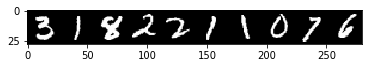

true label: 
[ 3.  1.  8.  2.  2.  1.  1.  0.  7.  6.]
<NDArray 10 @cpu(0)>
pred label: 
[ 3.  1.  8.  2.  2.  1.  1.  0.  3.  6.]
<NDArray 10 @cpu(0)>


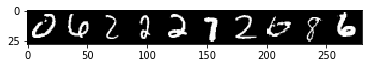

true label: 
[ 0.  6.  2.  2.  2.  7.  2.  6.  8.  6.]
<NDArray 10 @cpu(0)>
pred label: 
[ 6.  6.  2.  2.  2.  7.  2.  0.  3.  6.]
<NDArray 10 @cpu(0)>


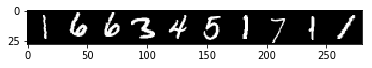

true label: 
[ 1.  6.  6.  3.  4.  5.  1.  7.  1.  1.]
<NDArray 10 @cpu(0)>
pred label: 
[ 1.  6.  6.  3.  4.  5.  1.  7.  1.  1.]
<NDArray 10 @cpu(0)>


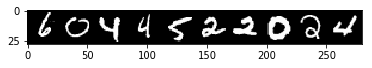

true label: 
[ 6.  0.  4.  4.  5.  2.  2.  0.  2.  4.]
<NDArray 10 @cpu(0)>
pred label: 
[ 6.  0.  4.  4.  5.  2.  2.  0.  2.  4.]
<NDArray 10 @cpu(0)>


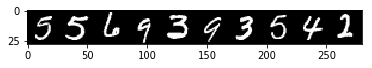

true label: 
[ 5.  5.  6.  9.  3.  9.  3.  5.  4.  2.]
<NDArray 10 @cpu(0)>
pred label: 
[ 5.  5.  6.  9.  3.  4.  3.  5.  4.  2.]
<NDArray 10 @cpu(0)>


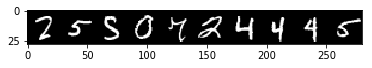

true label: 
[ 2.  5.  5.  0.  7.  2.  4.  4.  4.  5.]
<NDArray 10 @cpu(0)>
pred label: 
[ 2.  5.  5.  0.  7.  2.  4.  4.  4.  5.]
<NDArray 10 @cpu(0)>


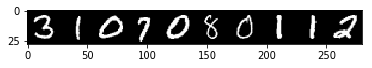

true label: 
[ 3.  1.  0.  7.  0.  8.  0.  1.  1.  2.]
<NDArray 10 @cpu(0)>
pred label: 
[ 3.  1.  0.  7.  0.  8.  0.  1.  1.  2.]
<NDArray 10 @cpu(0)>


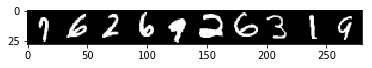

true label: 
[ 7.  6.  2.  6.  9.  2.  6.  3.  1.  9.]
<NDArray 10 @cpu(0)>
pred label: 
[ 7.  6.  2.  6.  9.  2.  6.  3.  1.  4.]
<NDArray 10 @cpu(0)>


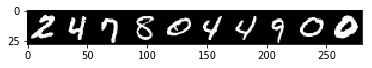

true label: 
[ 2.  4.  7.  8.  0.  4.  4.  9.  0.  0.]
<NDArray 10 @cpu(0)>
pred label: 
[ 8.  4.  7.  8.  0.  4.  4.  9.  0.  0.]
<NDArray 10 @cpu(0)>


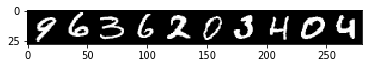

true label: 
[ 9.  6.  3.  6.  2.  0.  3.  4.  0.  4.]
<NDArray 10 @cpu(0)>
pred label: 
[ 9.  6.  3.  6.  2.  0.  3.  4.  0.  4.]
<NDArray 10 @cpu(0)>


In [26]:
def model_prediction(net, data):
    output = net(data)
    return nd.argmax(output, axis=1)

# 随机采样十个测试集中的样本点画出并观察预测结果
niter = 0
sample_data = gluon.data.DataLoader(mnist_test, 10, shuffle=True)
for i , (data, label) in enumerate(sample_data):
    im = nd.transpose(data, (1,0,2,3))
    im_concat = nd.reshape(im, (28, 10*28, 1))
    im_tile = nd.tile(im_concat, (1,1,3))
    plt.imshow(im_tile.asnumpy())
    plt.show()
    pred = model_prediction(net, data.reshape((data.shape[0], -1)))
    print("true label:", label)
    print("pred label:", pred)
    niter += 1
    if niter == 10:
        break

## ``nd.pick``的用法

In [29]:
x = nd.arange(6).reshape((3,2))
y = nd.array([0,1,1])
print(x)


[[ 0.  1.]
 [ 2.  3.]
 [ 4.  5.]]
<NDArray 3x2 @cpu(0)>


In [30]:
nd.pick(x, y, 1, keepdims=True)


[[ 0.]
 [ 3.]
 [ 5.]]
<NDArray 3x1 @cpu(0)>